# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. 

Specifically, this report will be targeted to stakeholders interested in opening an **French restaurant** in **Toronto**, Canada.

## Data <a name="data"></a>


a) To get all the information about the neighborhoods in Toronto, I will use “https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M” wiki page . This page has the postal code, borough & the name of all the neighborhoods present in Toronto.

b) I will use “ http://cocl.us/Geospatial_data” csv file to get the geographical coordinates of the neighborhoods.

c) To get location and other information about various venues in Toronto I will use Foursquare’s explore API. Using the Foursquare’s explore API (which gives venues recommendations), I’m fetching details about the venues up present in Toronto and collected their names, categories and locations (latitude and longitude).
From Foursquare API, I retrieved the following for each venue:
Name: The name of the venue.
Category: The category type as defined by the API.
Latitude: The latitude value of the venue.
Longitude: The longitude value of the venue.

### Let us first import the data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df_raw=df[0]
df_raw.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Data Cleaning

In [3]:
df_raw[df_raw["Neighbourhood"]== 'Not assigned']

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
7,M8A,Not assigned,Not assigned
10,M2B,Not assigned,Not assigned
15,M7B,Not assigned,Not assigned
...,...,...,...
174,M4Z,Not assigned,Not assigned
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned


In [4]:
df_clean=df_raw[~df_raw['Borough'].str.contains('Not assigned')]
df_clean

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


#### Now let us add geographical coordinates to the neighborhoods

In [5]:
neigh=pd.read_csv("https://cocl.us/Geospatial_data")
neigh.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
df3=df_clean.merge(neigh, on='Postal Code')
df3

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas in central Tornoto that have low restaurant density, particularly those with low number of French restaurants. 

We will limit our analysis to areas within 1km in central Tornoto

In first step we have collected the required **data: location and Neighbourhoods of Tornoto.

Second step in our analysis will be explore the category and'**restaurant density**' across different areas of Central Tornoto.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders:
we will take into consideration locations with **no more than two restaurants in radius of 1km**. 
We will create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

In [7]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')


Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


## Analysis <a name="analysis"></a>

In [8]:
address = 'Toronto'

geolocator = Nominatim(user_agent="tn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top

In [9]:
map_tn = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df3['Latitude'], df3['Longitude'], df3['Borough'], df3['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tn)  
    
map_tn

Let's simplify the above map and segment and cluster only the neighborhoods in Central Toronto.

In [10]:
Toronto_data= df3[df3['Borough'].str.contains('Central Toronto')].reset_index(drop=True)
Toronto_data.shape

(9, 5)

In [11]:
print('The Toronto dataframe has {} boroughs and {} neighourhoods'.format(len(Toronto_data['Borough'].unique()),Toronto_data.shape[0]) )

The Toronto dataframe has 1 boroughs and 9 neighourhoods


In [12]:
Toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197
3,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307
4,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678


As we did with all of Toronto, let's visualize Central Toronto neighborhoods

In [13]:
map_central = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_central)  
    
map_central

#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [14]:
Toronto_data.loc[0, 'Neighbourhood']

'Lawrence Park'

#### Get location data using Foursquare

In [15]:
!pip install geocoder
import geocoder
import requests
import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')


Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [16]:
address = 'Toronto'

geolocator = Nominatim(user_agent="TN_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [17]:
CLIENT_ID = '04FLOU31ELGGC4IEHHAUXUGCUS3GCE2XIZLHYPF0RZVR12VA' # your Foursquare ID
CLIENT_SECRET = 'ZREANKWAQ0DLH2CL0LPGCUCEGWDKQ2MAVGRQIOAZJD24H2HE' # your Foursquare Secret
ACCESS_TOKEN = 'FOPJUITJODG1FBTDSIPIVNRPQ2SKB3D1ACNFDS034QJ3NDQH' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 04FLOU31ELGGC4IEHHAUXUGCUS3GCE2XIZLHYPF0RZVR12VA
CLIENT_SECRET:ZREANKWAQ0DLH2CL0LPGCUCEGWDKQ2MAVGRQIOAZJD24H2HE


Get the neighborhood's latitude and longitude values.

In [18]:
neighborhood_latitude = Toronto_data.loc[0,'Latitude'] # neighborhood latitude value
neighborhood_longitude = Toronto_data.loc[0,'Longitude'] # neighborhood longitude value

neighborhood_name = Toronto_data.loc[0,'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Lawrence Park are 43.7280205, -79.3887901.


In [19]:
LIMIT = 100
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=04FLOU31ELGGC4IEHHAUXUGCUS3GCE2XIZLHYPF0RZVR12VA&client_secret=ZREANKWAQ0DLH2CL0LPGCUCEGWDKQ2MAVGRQIOAZJD24H2HE&v=20180604&ll=43.7280205,-79.3887901&radius=1000&limit=100'

In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '603b4062947ccc61762780c3'},
 'response': {'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 10,
  'suggestedBounds': {'ne': {'lat': 43.73702050900001,
    'lng': -79.37635882105461},
   'sw': {'lat': 43.71902049099999, 'lng': -79.40122137894538}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '50e6da19e4b0d8a78a0e9794',
       'name': 'Lawrence Park Ravine',
       'location': {'address': '3055 Yonge Street',
        'crossStreet': 'Lawrence Avenue East',
        'lat': 43.72696303913755,
        'lng': -79.39438246708775,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.72696303913755,
          'lng': -79.39438246708775}],
        'distance': 

In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.location.formattedAddress','venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(20)

<ipython-input-22-a7bab3d9f175>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,formattedAddress,categories,lat,lng
0,Lawrence Park Ravine,"[3055 Yonge Street (Lawrence Avenue East), Tor...",Park,43.726963,-79.394382
1,Granite Club,"[2350 Bayview Ave. (Lawrence Ave. West), Toron...",Gym / Fitness Center,43.733043,-79.381986
2,Tim Hortons,"[2275 Bayview Ave, Toronto ON M4N 3M6, Canada]",Coffee Shop,43.727324,-79.379563
3,TTC Bus #162 - Lawrence-Donway,"[Toronto ON, Canada]",Bus Line,43.728026,-79.382805
4,Glendon Bookstore,"[2275 Bayview Ave (Bayview and Lawrence), Toro...",Bookstore,43.727024,-79.378976
5,Glendon Forest,[2275 Bayview Ave (Bayview Avenue and Lawrence...,Trail,43.727226,-79.378413
6,Glendon Rose Garden,"[2275 Bayview Avenue (Lawrence Avenue), Toront...",College Quad,43.727334,-79.378222
7,Lunik Co-op,"[2275 Bayview Ave, Toronto ON, Canada]",Café,43.727311,-79.377835
8,Glendon Athletic Club,"[2275 Bayview Ave. (at Lawrence Ave. E), Toron...",College Gym,43.728799,-79.376819
9,TTC Bus #97 Yonge,"[Yonge St., Toronto ON, Canada]",Bus Line,43.727732,-79.401097


In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

10 venues were returned by Foursquare.


In [24]:
nearby_venues['Neighbourhood']='Lawrence Park'
nearby_venues

,name,formattedAddress,categories,lat,lng,Neighbourhood
0,Lawrence Park Ravine,"[3055 Yonge Street (Lawrence Avenue East), Tor...",Park,43.726963,-79.394382,Lawrence Park
1,Granite Club,"[2350 Bayview Ave. (Lawrence Ave. West), Toron...",Gym / Fitness Center,43.733043,-79.381986,Lawrence Park
2,Tim Hortons,"[2275 Bayview Ave, Toronto ON M4N 3M6, Canada]",Coffee Shop,43.727324,-79.379563,Lawrence Park
3,TTC Bus #162 - Lawrence-Donway,"[Toronto ON, Canada]",Bus Line,43.728026,-79.382805,Lawrence Park
4,Glendon Bookstore,"[2275 Bayview Ave (Bayview and Lawrence), Toro...",Bookstore,43.727024,-79.378976,Lawrence Park
5,Glendon Forest,[2275 Bayview Ave (Bayview Avenue and Lawrence...,Trail,43.727226,-79.378413,Lawrence Park
6,Glendon Rose Garden,"[2275 Bayview Avenue (Lawrence Avenue), Toront...",College Quad,43.727334,-79.378222,Lawrence Park
7,Lunik Co-op,"[2275 Bayview Ave, Toronto ON, Canada]",Café,43.727311,-79.377835,Lawrence Park
8,Glendon Athletic Club,"[2275 Bayview Ave. (at Lawrence Ave. E), Toron...",College Gym,43.728799,-79.376819,Lawrence Park
9,TTC Bus #97 Yonge,"[Yonge St., Toronto ON, Canada]",Bus Line,43.727732,-79.401097,Lawrence Park


#### Explore Neighborhoods in Central Toronto

Let's create a function to repeat the same process to all the neighborhoods in Central Toronto

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
central_venues = getNearbyVenues(names=Toronto_data['Neighbourhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude'])

Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park


In [27]:
print(central_venues.shape)
central_venues.head(50)

(565, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Granite Club,43.733043,-79.381986,Gym / Fitness Center
2,Lawrence Park,43.728020,-79.388790,Tim Hortons,43.727324,-79.379563,Coffee Shop
3,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
4,Lawrence Park,43.728020,-79.388790,Glendon Bookstore,43.727024,-79.378976,Bookstore
5,Lawrence Park,43.728020,-79.388790,Glendon Forest,43.727226,-79.378413,Trail
6,Lawrence Park,43.728020,-79.388790,Glendon Rose Garden,43.727334,-79.378222,College Quad
7,Lawrence Park,43.728020,-79.388790,Lunik Co-op,43.727311,-79.377835,Café
8,Lawrence Park,43.728020,-79.388790,Glendon Athletic Club,43.728799,-79.376819,College Gym
9,Lawrence Park,43.728020,-79.388790,TTC Bus #97 Yonge,43.727732,-79.401097,Bus Line


In [44]:
df_french=central_venues[central_venues['Venue Category'].str.contains('French Restaurant')]
df_french

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
263,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,Le Paradis,43.675007,-79.400036,French Restaurant
383,Davisville,43.704324,-79.388790,Coquine Restaurant,43.702623,-79.397429,French Restaurant
490,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,Scaramouche,43.681293,-79.399492,French Restaurant


In [29]:
central_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Davisville,100,100,100,100,100,100
Davisville North,100,100,100,100,100,100
"Forest Hill North & West, Forest Hill Road Park",47,47,47,47,47,47
Lawrence Park,10,10,10,10,10,10
"Moore Park, Summerhill East",56,56,56,56,56,56
"North Toronto West, Lawrence Park",45,45,45,45,45,45
Roselawn,28,28,28,28,28,28
"Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park",79,79,79,79,79,79
"The Annex, North Midtown, Yorkville",100,100,100,100,100,100


In [30]:
print('There are {} uniques categories.'.format(len(central_venues['Venue Category'].unique())))

There are 128 uniques categories.


## 3. Analyze Each Neighborhood

In [31]:
# one hot encoding
central_onehot = pd.get_dummies(central_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
central_onehot['Neighborhood'] = central_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [central_onehot.columns[-1]] + list(central_onehot.columns[:-1])
central_onehot = central_onehot[fixed_columns]

central_onehot.head()

,Yoga Studio,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Bar,Bike Shop,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Chinese Restaurant,Chiropractor,Clothing Store,Coffee Shop,College Gym,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Neighborhood,Park,Pastry Shop,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool Hall,Poutine Place,Pub,Ramen Restaurant,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,School,Seafood Restaurant,Skating Rink,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lawrence Park,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lawrence Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lawrence Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lawrence Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lawrence Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
central_onehot.shape

(565, 128)

#### let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [55]:
central_grouped = central_onehot.groupby('Neighborhood').mean().reset_index()
central_grouped.head(9)

,Neighborhood,Yoga Studio,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Bar,Bike Shop,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Chinese Restaurant,Chiropractor,Clothing Store,Coffee Shop,College Gym,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Park,Pastry Shop,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool Hall,Poutine Place,Pub,Ramen Restaurant,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,School,Seafood Restaurant,Skating Rink,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar
0,Davisville,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.010000,0.020000,0.01,0.00,0.00,0.000000,0.02,0.010000,0.01,0.01,0.000000,0.000000,0.040000,0.000000,0.000000,0.01,0.00,0.010000,0.000000,0.000000,0.000000,0.080000,0.0,0.0,0.00,0.01,0.000000,0.000000,0.010000,0.03,0.010000,0.00,0.00,0.000000,0.00,0.000000,0.01,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.01,0.000000,0.010000,0.010000,0.000000,0.000000,0.01,0.01,0.000000,0.030000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.010000,0.03,0.00,0.01,0.090000,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.010000,0.00,0.020000,0.030000,0.000000,0.02,0.00,0.00,0.00,0.010000,0.00,0.000000,0.000000,0.010000,0.000000,0.040000,0.000000,0.01,0.00,0.00,0.020000,0.010000,0.040000,0.01,0.000000,0.020000,0.00,0.010000,0.000000,0.000000,0.000000,0.00,0.00,0.010000,0.060000,0.01,0.01,0.00,0.01,0.010000,0.00,0.01,0.000000,0.000000,0.010000,0.01,0.00,0.010000,0.010000
1,Davisville North,0.020000,0.000000,0.00,0.000000,0.00,0.000000,0.010000,0.010000,0.00,0.00,0.00,0.000000,0.02,0.010000,0.01,0.01,0.000000,0.000000,0.040000,0.010000,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.010000,0.120000,0.0,0.0,0.00,0.01,0.010000,0.000000,0.010000,0.03,0.020000,0.01,0.00,0.000000,0.00,0.010000,0.00,0.030000,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.01,0.010000,0.030000,0.000000,0.000000,0.00,0.00,0.00,0.010000,0.000000,0.00,0.00,0.00,0.050000,0.010000,0.010000,0.00,0.000000,0.00,0.000000,0.00,0.010000,0.00,0.020000,0.000000,0.000000,0.02,0.00,0.00,0.00,0.010000,0.00,0.000000,0.000000,0.020000,0.000000,0.030000,0.000000,0.01,0.00,0.01,0.020000,0.020000,0.040000,0.02,0.010000,0.020000,0.00,0.010000,0.000000,0.010000,0.010000,0.00,0.00,0.020000,0.030000,0.00,0.01,0.00,0.00,0.020000,0.00,0.01,0.010000,0.000000,0.010000,0.00,0.00,0.010000,0.010000
2,"Forest Hill North & West, Forest Hill Road Park",0.000000,0.000000,0.00,0.000000,0.00,0.021277,0.021277,0.063830,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.042553,0.021277,0.063830,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.063830,0.0,0.0,0.00,0.00,0.000000,0.000000,0.021277,0.00,0.000000,0.00

In [34]:
central_grouped.shape

(9, 128)

In [76]:
df_index=central_grouped
df_indexneigh=df_index.set_index('Neighborhood')

In [78]:
df_indexneigh.head()

,Yoga Studio,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Bar,Bike Shop,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Chinese Restaurant,Chiropractor,Clothing Store,Coffee Shop,College Gym,College Quad,Concert Hall,Convenience Store,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Park,Pastry Shop,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool Hall,Poutine Place,Pub,Ramen Restaurant,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,School,Seafood Restaurant,Skating Rink,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Davisville,0.010000,0.000000,0.0,0.0,0.0,0.000000,0.010000,0.020000,0.01,0.0,0.0,0.0,0.02,0.010000,0.01,0.01,0.000000,0.000000,0.040000,0.000000,0.000000,0.01,0.0,0.010000,0.00,0.000000,0.00,0.080000,0.0,0.0,0.0,0.01,0.00,0.0,0.010000,0.03,0.01,0.00,0.0,0.0,0.0,0.00,0.01,0.020000,0.0,0.00,0.01,0.000000,0.0,0.01,0.01,0.000000,0.010000,0.010000,0.000000,0.0,0.01,0.01,0.000000,0.030000,0.000000,0.0,0.0,0.0,0.0,0.00,0.010000,0.03,0.0,0.01,0.090000,0.010000,0.00,0.0,0.000000,0.0,0.0,0.0,0.010000,0.0,0.02,0.030000,0.000000,0.02,0.0,0.0,0.0,0.010000,0.0,0.000000,0.0,0.010000,0.0,0.040000,0.000000,0.01,0.0,0.00,0.020000,0.01,0.040000,0.01,0.000000,0.020000,0.0,0.010000,0.000000,0.00,0.00,0.0,0.0,0.01,0.060000,0.01,0.01,0.0,0.01,0.010000,0.0,0.01,0.00,0.000000,0.010000,0.01,0.0,0.010000,0.01
Davisville North,0.020000,0.000000,0.0,0.0,0.0,0.000000,0.010000,0.010000,0.00,0.0,0.0,0.0,0.02,0.010000,0.01,0.01,0.000000,0.000000,0.040000,0.010000,0.000000,0.00,0.0,0.000000,0.01,0.000000,0.01,0.120000,0.0,0.0,0.0,0.01,0.01,0.0,0.010000,0.03,0.02,0.01,0.0,0.0,0.0,0.01,0.00,0.030000,0.0,0.02,0.00,0.000000,0.0,0.01,0.01,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.01,0.010000,0.030000,0.000000,0.0,0.0,0.0,0.0,0.01,0.000000,0.00,0.0,0.00,0.050000,0.010000,0.01,0.0,0.000000,0.0,0.0,0.0,0.010000,0.0,0.02,0.000000,0.000000,0.02,0.0,0.0,0.0,0.010000,0.0,0.000000,0.0,0.020000,0.0,0.030000,0.000000,0.01,0.0,0.01,0.020000,0.02,0.040000,0.02,0.010000,0.020000,0.0,0.010000,0.000000,0.01,0.01,0.0,0.0,0.02,0.030000,0.00,0.01,0.0,0.00,0.020000,0.0,0.01,0.01,0.000000,0.010000,0.00,0.0,0.010000,0.01
"Forest Hill North & West, Forest Hill Road Park",0.000000,0.000000,0.0,0.0,0.0,0.021277,0.021277,0.063830,0.00,0.0,0.0,0.0,0.00,0.000000,0.00,0.00,0.042553,0.021277,0.063830,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.00,0.063830,0.0,0.0,0.0,0.00,0.00,0.0,0.021277,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.021277,0.0,0.00,0.00,0.000000,0.0,0.00,0.00,0.021277,0.021277,0.021277,0.000000,0.0,0.00,0.00,0.000000,0.021277,0.042553,0.0,0.0,0.0,0.0,0.00,0.021277,0.00,0.0,0.00,0.042553,0.042553,0.00,0.0

In [89]:
df_indexneigh1=df_indexneigh.filter(like='Restaurant')

In [94]:
df_indexneigh1.head(8)

,American Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Persian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Syrian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Davisville,0.000000,0.000000,0.000000,0.01,0.000000,0.0,0.020000,0.010000,0.000000,0.01,0.03,0.01,0.090000,0.010000,0.0,0.0,0.0,0.020000,0.030000,0.000000,0.000000,0.010000,0.040000,0.010000,0.060000,0.01,0.010000,0.010000,0.010000
Davisville North,0.000000,0.000000,0.000000,0.00,0.010000,0.0,0.030000,0.000000,0.000000,0.01,0.00,0.00,0.050000,0.010000,0.0,0.0,0.0,0.020000,0.000000,0.000000,0.000000,0.020000,0.040000,0.010000,0.030000,0.00,0.020000,0.010000,0.010000
"Forest Hill North & West, Forest Hill Road Park",0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.021277,0.000000,0.000000,0.00,0.00,0.00,0.042553,0.042553,0.0,0.0,0.0,0.000000,0.021277,0.000000,0.021277,0.000000,0.021277,0.000000,0.042553,0.00,0.000000,0.021277,0.000000
Lawrence Park,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
"Moore Park, Summerhill East",0.017857,0.000000,0.017857,0.00,0.000000,0.0,0.000000,0.000000,0.017857,0.00,0.00,0.00,0.071429,0.017857,0.0,0.0,0.0,0.000000,0.000000,0.017857,0.000000,0.000000,0.035714,0.017857,0.035714,0.00,0.053571,0.000000,0.017857
"North Toronto West, Lawrence Park",0.000000,0.000000,0.000000,0.00,0.022222,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.066667,0.000000,0.0,0.0,0.0,0.044444,0.000000,0.000000,0.000000,0.022222,0.044444,0.000000,0.022222,0.00,0.044444,0.000000,0.022222
Roselawn,0.000000,0.035714,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.071429,0.035714,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107143,0.00,0.000000,0.000000,0.000000
"Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park",0.012658,0.000000,0.012658,0.00,0.000000,0.0,0.000000,0.012658,0.012658,0.00,0.00,0.00,0.050633,0.012658,0.0,0.0,0.0,0.000000,0.000000,0.012658,0.000000,0.000000,0.025316,0.012658,0.063291,0.00,0.050633,0.012658,0.012658


In [91]:
df_indexneigh1.describe()

,American Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Persian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Syrian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.004502,0.003968,0.003391,0.001111,0.003580,0.001111,0.007920,0.003629,0.003391,0.003333,0.004444,0.001111,0.054746,0.015420,0.001111,0.001111,0.001111,0.011605,0.007920,0.004502,0.002364,0.005802,0.026306,0.005613,0.041214,0.001111,0.022072,0.010437,0.008082
std,0.007042,0.011905,0.006852,0.003333,0.007734,0.003333,0.012187,0.005497,0.006852,0.005000,0.010138,0.003333,0.025371,0.014686,0.003333,0.003333,0.003333,0.015665,0.012187,0.007042,0.007092,0.009293,0.016645,0.007032,0.032362,0.003333,0.022148,0.013381,0.008552
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050633,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.035714,0.000000,0.020000,0.010000,0.010000
75%,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000,0.000000,0.010000,0.000000,0.000000,0.071429,0.017857,0.000000,0.000000,0.000000,0.020000,0.020000,0.010000,0.000000,0.010000,0.040000,0.010000,0.060000,0.000000,0.044444,0.012658,0.012658
max,0.017857,0.035714,0.017857,0.010000,0.022222,0.010000,0.030000,0.012658,0.017857,0.010000,0.030000,0.010000,0.090000,0.042553,0.010000,0.010000,0.010000,0.044444,0.030000,0.017857,0.021277,0.022222,0.044444,0.017857,0.107143,0.010000,0.053571,0.040000,0.022222


#### Let's print each neighborhood along with the top 5 most common venues

In [35]:
num_top_venues = 5

for hood in central_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = central_grouped[central_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Davisville----
                venue  freq
0  Italian Restaurant  0.09
1         Coffee Shop  0.08
2    Sushi Restaurant  0.06
3         Pizza Place  0.04
4                Café  0.04


----Davisville North----
                venue  freq
0         Coffee Shop  0.12
1  Italian Restaurant  0.05
2          Restaurant  0.04
3                Café  0.04
4        Dessert Shop  0.03


----Forest Hill North & West, Forest Hill Road Park----
                 venue  freq
0                 Park  0.09
1                 Café  0.06
2          Coffee Shop  0.06
3                 Bank  0.06
4  Japanese Restaurant  0.04


----Lawrence Park----
                  venue  freq
0              Bus Line   0.2
1                  Café   0.1
2  Gym / Fitness Center   0.1
3                  Park   0.1
4           Coffee Shop   0.1


----Moore Park, Summerhill East----
                venue  freq
0                Park  0.07
1  Italian Restaurant  0.07
2         Coffee Shop  0.07
3       Grocery Store  0.07
4   

#### Let's put that into a _pandas_ dataframe

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = central_grouped['Neighborhood']

for ind in np.arange(central_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(central_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Davisville,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Café,Restaurant,Middle Eastern Restaurant,Indian Restaurant,Dessert Shop,Gym
1,Davisville North,Coffee Shop,Italian Restaurant,Café,Restaurant,Fast Food Restaurant,Gym,Pizza Place,Sushi Restaurant,Dessert Shop,Yoga Studio
2,"Forest Hill North & West, Forest Hill Road Park",Park,Bank,Coffee Shop,Café,Sushi Restaurant,Trail,Pharmacy,Burger Joint,Italian Restaurant,Gym / Fitness Center
3,Lawrence Park,Bus Line,Gym / Fitness Center,College Gym,Bookstore,Coffee Shop,Café,Trail,College Quad,Park,Dog Run
4,"Moore Park, Summerhill East",Park,Coffee Shop,Grocery Store,Italian Restaurant,Gym,Thai Restaurant,Café,Restaurant,Pizza Place,Sushi Restaurant


#### Exploratory Data Analysis

In [38]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


<AxesSubplot:xlabel='Venue Category', ylabel='count'>

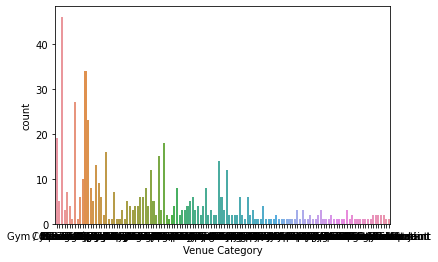

In [42]:
sns.countplot(x='Venue Category', data=central_venues)

#### 4.1 Clustering Neighborhoods of Toronto:


Run _k_-means to cluster the neighborhood into 5 clusters.

In [ ]:
# set number of clusters
kclusters = 5

central_grouped_clustering = central_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(central_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

In [ ]:
#add clustering labels
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

central_merged = Toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
central_merged = central_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

central_merged.head() # check the last columns!

###### visualize the resulting clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(central_merged['Latitude'], central_merged['Longitude'], central_merged['Neighbourhood'], central_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Cluster 1

In [ ]:
central_merged.loc[central_merged['Cluster Labels'] == 0, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

#### Cluster 2

In [ ]:
central_merged.loc[central_merged['Cluster Labels'] == 1, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

#### Cluster 3

In [ ]:
central_merged.loc[central_merged['Cluster Labels'] == 2, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

#### Cluster 4

In [ ]:
central_merged.loc[central_merged['Cluster Labels'] == 3, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

#### Cluster 5

In [ ]:
central_merged.loc[central_merged['Cluster Labels'] == 4, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

## Results and Discussion:<a name=" Results and Discussion"></a>


Our analysis shows that although there are many restaurants in central Tornoto (close to 170 in a radius of 1 km).

There are pockets of low restaurant density fairly such as Lawrence Park.

Highest concentration of type of restaurants was detected as Italian followed by Mexican, Japanese and Asian.

After directing our attention central tornoto and nearby venues, we
clustered to create zones of interest which contain greatest number of location candidates. 
Purpose of this analysis was to only provide info on areas close to central Tornoto but not crowded with existing restaurants.
it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

In [ ]:
Purpose of this project was to identify central tornoto areas with low number of restaurants (particularly French restaurants) in order to aid stakeholders in narrowing down the search for optimal location for a new French restaurant. 
By calculating restaurant density distribution from Foursquare data we have first identified neighborhoods that justify further analysis  and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. 
Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.